# Kinetics IV

Today, we'll discuss analysis of kinetic data obtained in a CSTR.  We'll consider the impacts of measurement error and how it can be managed, and we'll also discuss strategies for extracing meaningful parameter estimates from a maddening set of data that were not obtained very systematically.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01: Analysis of Perfect Data

The following reaction is carried out in a CSTR at steady state $(V = 0.275\mathrm{L})$.  The experiment is performed by varying the inlet volumetric flowrate, $Q_f$, of a feed solution that has a concentration $C_{A_f} = 10 \ \mathrm{mol \ L^{-1}}$.  You may assume the fluid density is constant so that $Q = Q_f$.

$$A \longrightarrow B$$

At each value of $Q_f$, you measure the concentration of species $A$ and species $B$ in the effluent stream. The data are stored as arrays in the code cell below. For now, we'll look at essentially perfect data just to get a feel for the way that we handle the analysis without also dealing with precision and measurement uncertainty. Then, we will consider the impacts of precision and measurement uncertainty on our analysis.

You may assume that the reaction rate is described by power law kinetics:

$$r = kC_A^{\alpha}$$

where $\alpha$ is an integer. 

Please determine the reaction order in $A$ and the rate constant for this reaction.

**Answer**: $\alpha = 1$, $k = 0.023 \ \mathrm{s^{-1}}$

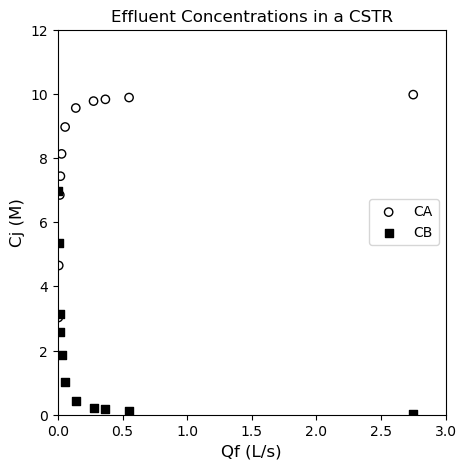

In [4]:
########################################################################################################
# Define global constants                                                                              #
########################################################################################################

V      = 0.275 #L
CAf    = 10    #mol/L

########################################################################################################
# Storing *nearly* exact CA and Qf values in numpy arrays -- I kept 11 decimal places in calculation   #
########################################################################################################

Qftrue = np.array([2.7500000000, 0.5500000000, 0.3666666667, 0.2750000000, 0.1375000000, 0.0550000000, 0.0275000000, 0.0183333333, 0.0137500000, 0.0055000000, 0.0027500000]) #L/sec
CAtrue = np.array([9.9770527786, 9.8863074642, 9.8304251659, 9.7751710655, 9.5602294455, 8.9686098655, 8.1300813008, 7.4349442379, 6.8493150685, 4.6511627907, 3.0303030303]) #mol/L
CBtrue = np.array([0.0229472214, 0.1136925358, 0.1695748341, 0.2248289345, 0.4397705545, 1.0313901345, 1.8699186992, 2.5650557655, 3.1506849315, 5.3488372093, 6.9696969697]) #mol/L 

########################################################################################################
# Scatterplot of raw data CA (exit) vs Qf                                                              #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(Qftrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'CA')
plt.scatter(Qftrue, CBtrue, marker = 's', color = 'black', edgecolor = 'black', label = 'CB')
plt.title('Effluent Concentrations in a CSTR', fontsize = 12)
plt.xlabel('Qf (L/s)', fontsize = 12)
plt.ylabel('Cj (M)', fontsize = 12)
plt.xlim(0, 3)
plt.ylim(0, 12)
plt.legend(loc = 'right')
plt.show()

### Solution to Example Problem 01

Let's stick with our conventional wisdom that, if we want to determine the reaction order with respect to $A$, we need to know how the rate of reaction changes in response to changes in the concentration of species $A$. This is easiest to do if everything else is constant. Fortunately, these reactions are performed at constant temperature and in a solvent, so the fluid density is constant. Also, we know from the problem statement that the rate of reaction ***does not*** depend on the concentration of species $B$. This allows us to focus on how changing the concentration of $A$ will impact the rate of reaction.  We have available to us a set of concentrations of species $A$, $C_A$, measured at various values of feed volumetric flowrate, $Q_f$. Let's see how we could use this to estimate a reaction order and rate constant.

#### Estimation of reaction rates in a CSTR at Steady State

As with a batch reactor, the starting point for this analysis is a material balance. We will choose to work with a balance on $A$. The problem statement requests information about the order in $A$, so this is a sensible and intuitive approach. 

```{note}
We are interested in determining the reaction order in species $A$. One good way to do this is to find a way to estimate reaction rates as a function of $C_A$ as in a differential analysis of Batch Reactor data. If we could find a way to do this, we could linearize the power law rate expression and estimate the reaction order and rate constant. It turns out that, for a single reaction in a CSTR, we can calculate the rate of reaction directly by solving the material balance.
```

For a CSTR at steady state, the material balance on species $A$ is:

$$0 = F_{A,f} - F_{A} + R_AV$$

We are given data about concentrations and volumetric flowrates (instead of molar flowrates, $F_j$), so we can recast this balance in terms of these parameters:

$$0 = C_{A,f}Q_f - C_AQ_f + R_AV$$

Dividing through by the feed volumetric flowrate, we get:

$$0 = C_{A,f} - C_A + R_A\tau$$

We recognize that we have a single reaction, we can make the substitution that $R_A = -r$:

$$0 = C_{A,f} - C_A - r\tau$$

And we can solve for $r$ to get:

$$r = \frac{C_{A,f} - C_A}{\tau}$$

Interesting! In a CSTR, dividing $\Delta C_A$ by $\Delta \tau$ gives us a direct calculation of reaction rate at the concentration inside of the CSTR (rather than a finite difference approximation like in a batch reactor). That seems promising! Once we have calculated a reaction rate, we should consider that this measurement reflects the spatially averaged rate of reaction inside of the CSTR. Since the CSTR is a well-mixed reactor, species concentration inside of the reactor is uniform and equal to species concentration in the effluent. As such, solving for $r$ at each experimental condition will generate us a set of reaction rates at various concentrations of $A$. As things stand now, we have a set of $r$ vs. $C_A$ data.  We have proposed that rate scales with $C_A$ following power law kinetics (with an unknown reaction order α):

$$r = kC_A^{\alpha}$$

As presented in previous Notebooks (see [Notebook 39](https://jqbond.github.io/CEN587/Notebooks/587-N39.html)), we can linearize a power law model using a logarithmic transformation:

$$\ln(r) = \ln(k) + \alpha \ln(C_A)$$

If the rate truly follows power law kinetics, we should see linearity if we graph $\ln(r)$ vs. $\ln(C_A)$, and we can regress the slope and intercept to estimate the reaction order and rate constant.

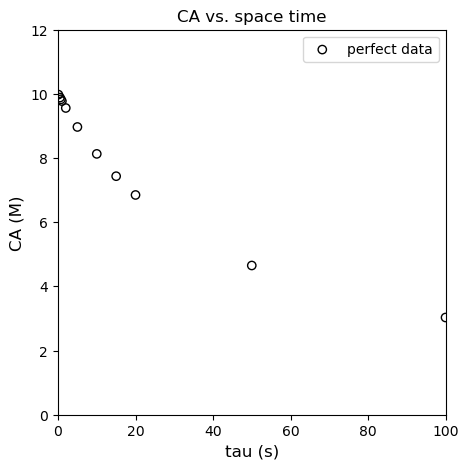

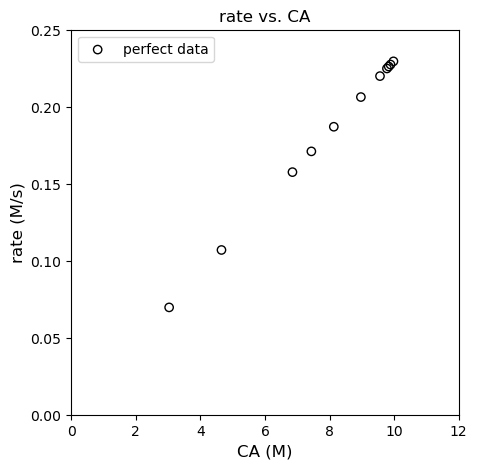

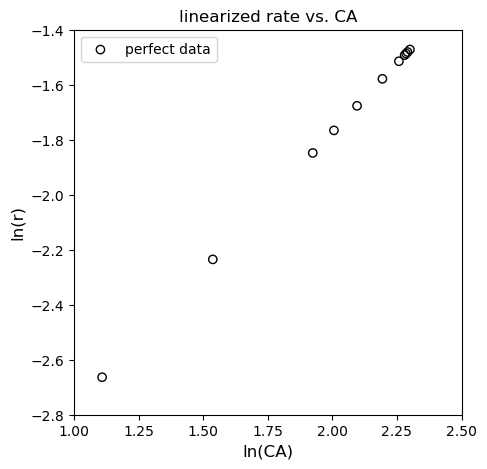

In [5]:
########################################################################################################
# Calculate resultant set of space times from varying Qf                                               #
########################################################################################################

τtrue  = V/Qftrue

########################################################################################################
# Calculate reaction rates                                                                             #
########################################################################################################

rtrue  = (CAf - CAtrue)/τtrue

########################################################################################################
# Create scatterplot of CA vs. τ data                                                                  #
# Looks a bit like a CA vs. t data set for a batch, but this is CA vs "space" time, not "clock" time   #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.xlabel('tau (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.title('CA vs. space time')
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of r vs. CA data                                                                  #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (M/s)', fontsize = 12)
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of ln(r) vs. ln(CA) data                                                          #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('ln(r)', fontsize = 12)
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.legend()
plt.show()

#### Linear Regression on Perfect Data (generated by solving material balance)

In the cell below, we regress values for the slope and intercept, which give us information about the reaction order and rate constant. We also report confidence intervals on parameter estimates as well as various metrics that help us to quantify goodness-of-fit. 

m    =  1.00e+00 +/- 1.13e-09
b    = -3.77e+00 +/- 2.32e-09
SSE  =      0.00
SST  =      1.46
MSE  =      0.00
RMSE =      0.00
R2   =      1.00
α    =  1.00e+00 +/- 1.13e-09
k    =  2.30e-02 (but is between 2.30e-02 and 2.30e-02)


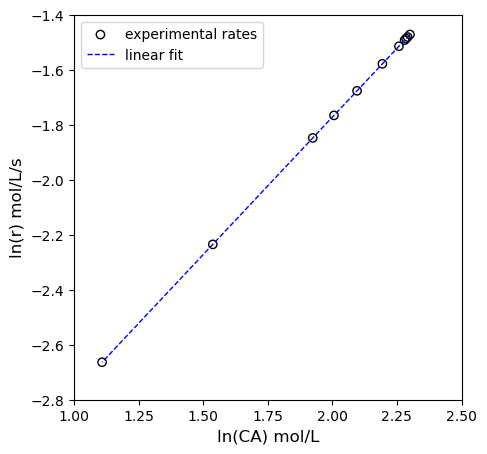

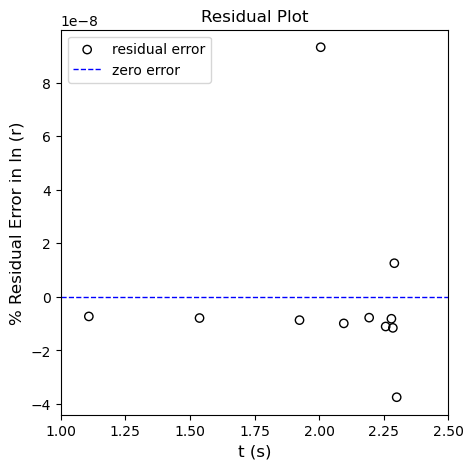

In [7]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(rtrue)
xdata = np.log(CAtrue)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()

From this analysis, we would conclude that we are very confident that the reaction is first order in $A$ and that the value of the first order rate constant is $k = 0.023 \ \mathrm{s^{-1}}$. Note that these agree with the exact values of $\alpha$ and $k$ given in the problem statement, and there is essentially zero uncertainty in the estimates. We also see absurdly good values for our residual sum of squares $SSE = 0.00$ and coefficient of determination $R^2 = 1.00$, but that is what we might expect when performing statistical analysis on exact data. Next, let's see what happens if we truncate data. This is a simple acknowledgement of the fact that we absolutely cannot make a measurement that is accurate to 10 decimal places in the laboratory. Even if our measurement is exactly right, we will not usually be able to report more than 3 significant figures, so let's truncate the data accordingly.

## Example Problem 02: Analysis of (Slightly) More Realistic Data

Now let's work toward what a real data set might look like.  First, we'd never keep 10 decimal places for data we generated from laboratory measurements, e.g., gas-chromatography, sample masses, etc. There are too many significant figures for real data where our precision is limited by measurement uncertainty. Let's round the "perfect" data in the above arrays to expected experimental precision. We will now consider the perfect data truncated to 3 significant figures. Values are stored as numpy arrays in the code cell below.  

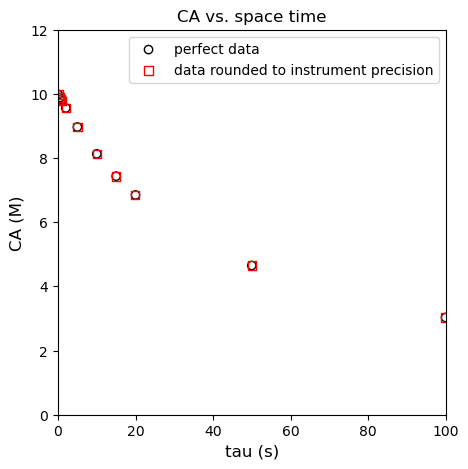

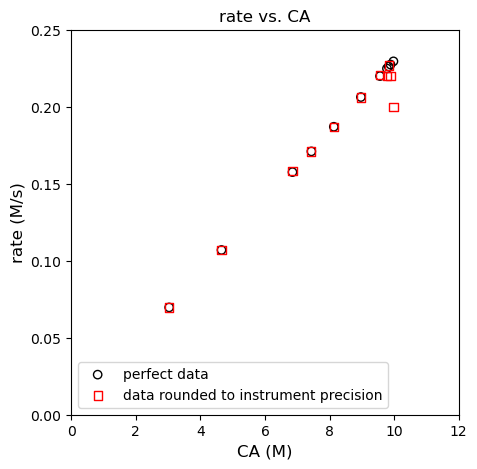

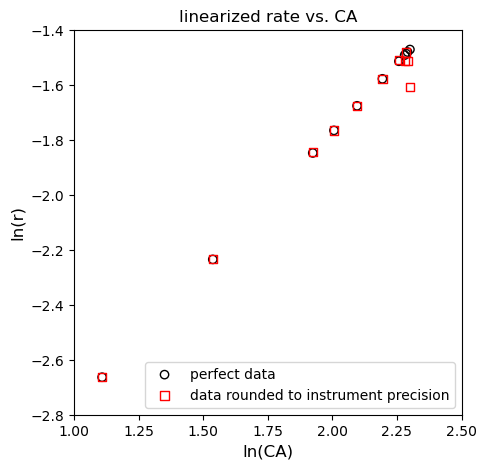

In [8]:
########################################################################################################
# Store calculated "perfect" data rounded to instrument precision (3 sig figs) in numpy arrays         #
########################################################################################################

Qfdata = np.array([2.75, 0.55, 0.367, 0.275, 0.138, 0.055, 0.0275, 0.0183, 0.0138, 0.0055, 0.00275]) #mol/L
CAdata = np.array([9.98, 9.89, 9.83, 9.78, 9.56, 8.97, 8.13, 7.43, 6.85, 4.65, 3.03]) #L/sec

########################################################################################################
# Calculate space times and rates from data truncated to 3 significant figures                         #
########################################################################################################

τdata  = V/Qfdata
rdata  = (CAf - CAdata)/τdata

########################################################################################################
# Create scatterplot of CA vs. τ data; overlay "true" vs. "truncated"                                  #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(τdata, CAdata, marker = 's', color = 'none', edgecolor = 'red', label = 'data rounded to instrument precision')
plt.xlabel('tau (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 100)
plt.ylim(0, 12)
plt.title('CA vs. space time')
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of rate vs. CA data; overlay "true" vs. "truncated"                               #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(CAdata, rdata, marker = 's', color = 'none', edgecolor = 'red', label = 'data rounded to instrument precision')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (M/s)', fontsize = 12)
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of ln(rate) vs. ln(CA) data; overlay "true" vs. "truncated"                       #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(np.log(CAdata), np.log(rdata), marker = 's', color = 'none', edgecolor = 'red', label = 'data rounded to instrument precision')
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('ln(r)', fontsize = 12)
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.legend()
plt.show()

########################################################################################################
# If desired, uncomment lines below to print out true vs. truncated data and % error in CA and r       #
########################################################################################################

# display(np.round(np.vstack((CAtrue, CAdata, (CAtrue - CAdata)*100/CAtrue)).T, 3))
# display(np.round(np.vstack((rtrue, rdata, (rtrue - rdata)*100/rtrue)).T, 3))

### Linear Regression on Data Rounded to Instrument Precision

We can see that something as simple as truncating data to 3 significant figures begins to create some issues in our estimates of reaction rates. Overall, the linearized data still look mostly linear, though we start to see large variations and scatter at very high concentrations of A (this is at very small values of τ). Next, let's work through the regression analysis and see if our parameter estimates and goodness-of-fit metrics have changed significantly.

```{important}
This next analysis demonstrates the impact of limited precision in reporting data. Our numbers do not have any measurement error added yet, they are simply rounded to 3 significant figures!
```

m    =  9.65e-01 +/- 7.85e-02
b    = -3.72e+00 +/- 1.62e-01
SSE  =      0.02
SST  =      1.37
MSE  =      0.00
RMSE =      0.04
R2   =      0.99
α    =  9.65e-01 +/- 7.85e-02
k    =  2.43e-02 (but is between 2.07e-02 and 2.86e-02)


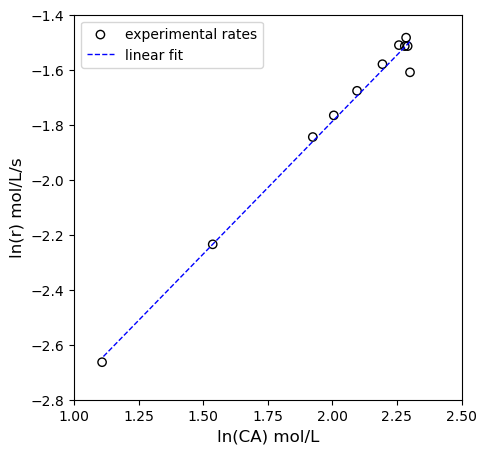

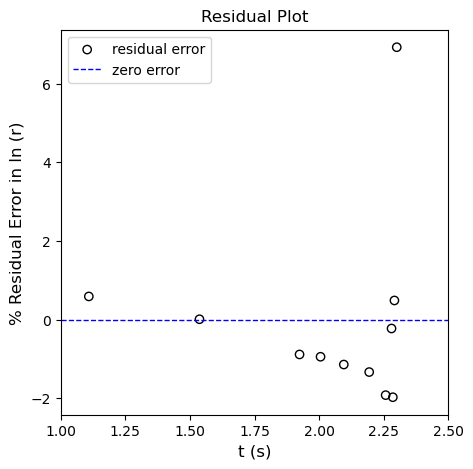

In [9]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(rdata)
xdata = np.log(CAdata)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()

Now we have some quantitative results to work with, and we can see that truncating data to account for instrument precision has substantially reduced our confidence in parameter estimates. For example, here we conclude that $\alpha = 0.97 \pm 0.08$ and that $0.021 \ \mathrm{s^{-1}} \leq k \leq 0.029 \ \mathrm{s^{-1}}$, and we find a slight increase in residual sum of squares $(SSE = 0.02)$ and a slight decrease in coefficient of determination $(R^2 = 0.99)$. The fit is still overall very good, and we would be reasonably confident about these results, but the impact is suprisingly large considering the seeminly minor level of processing that we've applied to the data in rounding all numbers to three significant figures.

## Example 03: Processing Noisy Data (simulating a real experiment)

In the real world, we can rarely measure a quantity with absolute precision. Above, we simply rounded exact numbers to 3 significant figures, but here, we will acknowledge the fact that our measurements are never exact. At best, they will have a small amount of random scatter, and if we make many measurements, their mean will approach the exact value. Next, we are going to make our data ***resemble*** something we would get in a lab by adding random noise to each exact number obtained by solving the material balance on a CSTR. Here, we are adding Gaussian noise to our measurements of $C_A$. We use `numpy.random.normal()` to generate a random number from a Gaussian distribution that has a given mean and standard deviation. We scale the size of the random noise by the size of $C_A$ -- this makes sense. The absolute uncertainty in a small value of $C_A$ is much smaller than the absolute uncertainty in a large value of $C_A$. For example, if I measure $C_A = 10.0 \ \mathrm{M}$, I might acknowledge that experimental uncertainty suggests I can only be sure about that number within a few percent -- let's say 5%.  A better way to think about that measurement would then be that $C_A = 10.0 \pm 0.5 \ \mathrm{M}$ or that, if I were to measure the concentration of $A$ again, I might not be surprised if I measure $9.5 \ \mathrm{M} \leq C_A \leq 10.5 \ \mathrm{M}$.  By contrast, if I measured $C_A = 0.1 \ \mathrm{M}$, my expectations would shift to maybe $C_A = 0.1 \pm 0.005 \ \mathrm{M}$ or $0.095 \ \mathrm{M} \leq C_A \leq 0.105 \ \mathrm{M}$.

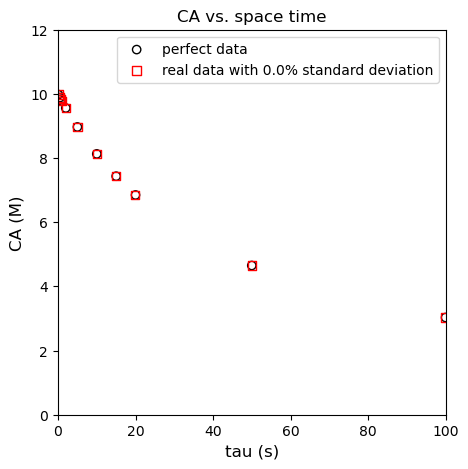

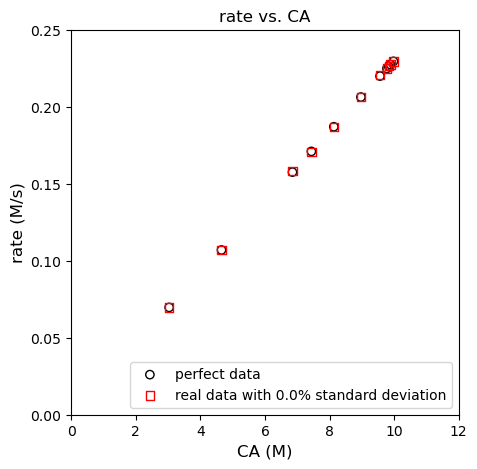

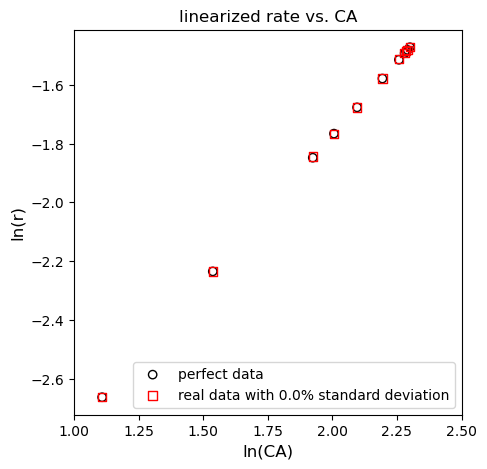

In [31]:
#############################################################################################################
# Set the noise level for this experiment                                                                   #
#############################################################################################################

noise_level = 0.0   #percent standard deviation on the mean.

#############################################################################################################
# Key the seed for the randon number generation to the noise level                                          #
# This ensures that, for a given noise level, the RNG will generate the same set of "random" noise values   #
# This is done so that each time we run the notebook, we get a predictable result                           #
#############################################################################################################

np.random.seed(ceil(noise_level))

#############################################################################################################
# Add gaussian noise to data to simulate measurement uncertainty                                            #
#############################################################################################################

noiseA  = CAtrue*np.random.normal(0, noise_level/100, CAtrue.shape)
CAdatan = CAtrue + noiseA

#############################################################################################################
# Use noisy Concentration measurements to calculate rates                                                   #
#############################################################################################################

rdatan  = (CAf - CAdatan)/τdata

########################################################################################################
# Create scatterplot of CA vs. τ data; overlay "true" vs. "noisy"                                      #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CAtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(τdata, CAdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('tau (s)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 100)
# plt.xlim(0, 5)
plt.ylim(0, 12)
# plt.ylim(9, 11)
plt.title('CA vs. space time')
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of rate vs. CA data; overlay "true" vs. "noisy"                                   #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(CAdatan, rdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('CA (M)', fontsize = 12)
plt.ylabel('rate (M/s)', fontsize = 12)
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend(loc = 'lower right')
plt.show()

########################################################################################################
# Create scatterplot of ln(rate) vs. ln(CA) data; overlay "true" vs. "noisy"                           #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(np.log(CAdatan), np.log(rdatan), marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('ln(CA)', fontsize = 12)
plt.ylabel('ln(r)', fontsize = 12)
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.legend()
plt.show()

########################################################################################################
# If desired, uncomment lines below to print out true vs. truncated data and % error in CA and r       #
########################################################################################################

# display(np.vstack((CAtrue, CAdatan, (CAtrue - CAdatan)*100/CAtrue)).T)
# display(np.round(np.vstack((rtrue, rdatan, (rtrue - rdatan)*100/rtrue)).T, 3))

### Linear Regression on Noisy Data

We can see from the above overlays that there is a substantial impact from considering noisy data. Even at modest levels of imprecision, errors begin to appear in our concentration measurements. These are amplified in our estimates of reaction rates. Let's see if applying regression analysis can still smooth this out and give us reasonable estimates of rate constant and reaction order.

m    =  1.00e+00 +/- 3.21e-03
b    = -3.77e+00 +/- 6.61e-03
SSE  =      0.00
SST  =      1.46
MSE  =      0.00
RMSE =      0.00
R2   =      1.00
α    =  1.00e+00 +/- 3.21e-03
k    =  2.30e-02 (but is between 2.28e-02 and 2.31e-02)


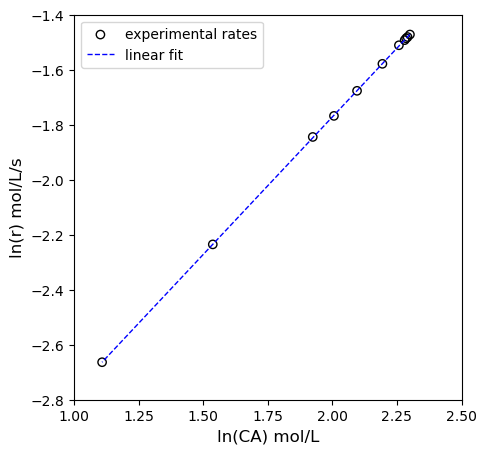

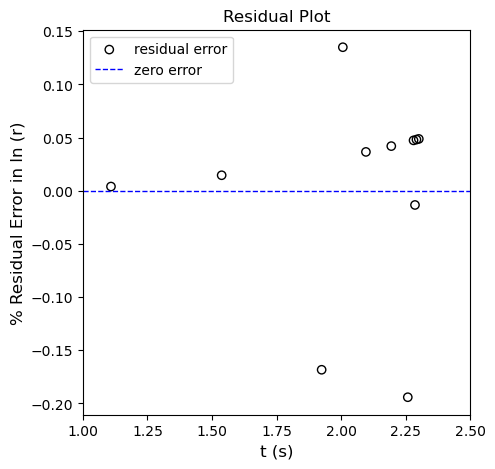

In [23]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(rdatan)
xdata = np.log(CAdatan)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.xlabel('t (s)', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()

Even for small levels of uncertainty ($\sigma \approx 0.1 \%$), we see large uncertainty in parameter estimates. The estimated reaction order $\alpha$ is now $0.7 \pm 0.7$, decreasing our confidence that this reaction is first order in $A$. Similarly, we estimate bounds on the rate constant that span nearly 2 orders of magnitude $(0.007 \leq k \ \leq 0.14)$. For slightly larger values of standard deviation (but still very small levels of imprecision, such as $\sigma \approx 1 \%$), we begin seeing NAN errors that cause our linear regression analysis to fail. This seems like an outsized impact of 1% uncertainty in our concentration mesurements, and we should consider what is happening because it is a common issue in kinetic analysis, and it is one that (usually) has a straightforward resolution.

The problem here is not in our logic or in our math...every aspect of our analysis is correct. The problem lies in our data, specifically in our ability to measure exact concentrations in the laboratory. Although it does not appear to cause serious deviations in the $C_A$ vs. $\tau$ trend (relative to the exact solution), it causes substantial errors in rate estimates, especially those obtained at short residence times and/or large values of $C_A$. Here is the reason why:

Consider our definition of $r$ in this CSTR, which arises from solving the material balance for species $A$ in a CSTR operating at steady state. It is based on measuring the change in the concentration of species $A$ relative to the feed at a given residence time:

$$r = \frac{C_{Af} - C_A}{\tau}$$

If we operate our reactor at very large values of $Q_f$, this drives our space times close to zero. At a space time of zero, our fractional conversion will also approach zero for the reason that species are effectively spending no time in the reactor.  

```{important}
Convince yourself that, for *this* CSTR at steady state, $X_A = r\tau/C_{Af}$
```

In the limit of zero conversion, we would expect that:

$$C_{Af} \approx C_A$$

This means the two quantities in the numerator of the rate definition, $C_{Af} - C_A$ are becoming nearly indistinguishable. Here's where measurement uncertainty becomes important. It only takes a bit of uncertainty in our measurements before we're getting results like $C_A > C_{Af}$ for very small values of $\tau$. Physically, that is impossible for this reaction, but our limits on precision make it something that we observe in noisy data at low conversion (small $\tau$). When we're in this situation of trying to determine reaction rates at nearly zero conversion, the better approach is to do this based on a balance on our product. We will consider this approach next.

## Example Problem 04: Leveraging Product Concentrations to estimate reaction rate

Recall that the original problem statement indicated that we'd measured the concentration of product. We looked at this data early on in the analysis, but we have not used it yet.  Now, we'll consider how this could be used (instead of the concentration of species $A$) to estimate reaction rates. This may be counterintuitive because we are used to experiments wherein we manipulate the concentration of reactant in order to determine the reaction order for that reactant. We are still doing that in this experiment, but we will use the effluent concentration of species $B$ instead of the the effluent concentration of species $A$ to estimate reaction rates. Although it seems minor, this will have a significant impact in our ability to tolerate measurement uncertainty in a kinetic analysis.  We'll start by writing a balance on species $B$:

$$0 = C_{Bf} - C_B + R_B\tau$$

Since $R_B = r$, this can be solved to give:

$$r = \frac{C_B}{\tau}$$

This measn that, when we estimate the reaction rate, we are using the change in concentration of species $B$ relative to zero (the inlet concentration of B). The measurement of $C_B$ is still subject to imprecision and uncertainty as usual, but we are not subtracting two nearly identical values in the numerator. This leads to much greater precision in our estimates for rate of reaction, especially in the limit of zero conversion. In the code cell below, we add noisy values of $C_B$ and proceed with using these to estimate reaction rates and compare the noisy data to the exact results presented earlier in the Notebook.

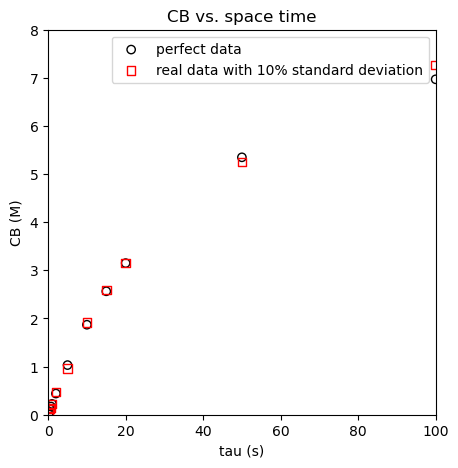

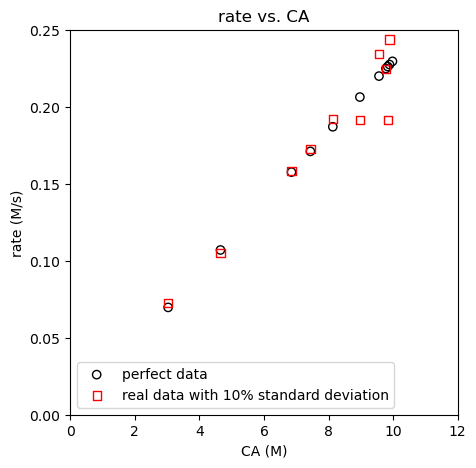

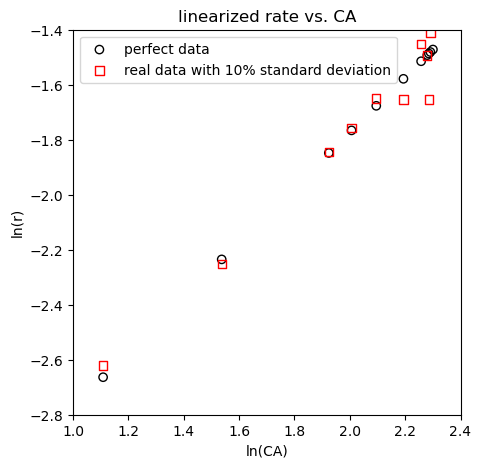

In [32]:
#############################################################################################################
# Set the noise level for this experiment                                                                   #
#############################################################################################################

noise_level = 10   #percent standard deviation on the mean.

#############################################################################################################
# Key the seed for the randon number generation to the noise level                                          #
# This ensures that, for a given noise level, the RNG will generate the same set of "random" noise values   #
# This is done so that each time we run the notebook, we get a predictable result                           #
#############################################################################################################

np.random.seed(ceil(noise_level))

#############################################################################################################
# Add gaussian noise to CB data to simulate measurement uncertainty                                         #
#############################################################################################################

noiseB   = CBtrue*np.random.normal(0, noise_level/100, CBtrue.shape)
CBdatan = CBtrue + noiseB

#############################################################################################################
# Use noisy Concentration measurements to calculate rates; also calculate true rates based on exact CB, τ   #
#############################################################################################################

rbtrue  = CBtrue/τtrue
rbdatan = CBdatan/τdata

########################################################################################################
# Create scatterplot of CB vs. τ data; overlay "true" vs. "noisy"                                      #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(τtrue, CBtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(τdata, CBdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('tau (s)')
plt.ylabel('CB (M)')
plt.title('CB vs. space time')
plt.xlim(0, 100)
plt.ylim(0, 8)
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of r vs. CA data; overlay "true" vs. "noisy"                                      #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(CAtrue, rbtrue, marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(CAdatan, rbdatan, marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('CA (M)')
plt.ylabel('rate (M/s)')
plt.title('rate vs. CA')
plt.xlim(0, 12)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

########################################################################################################
# Create scatterplot of ln(r) vs. ln(CA) data; overlay "true" vs. "noisy"                              #
########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.log(CAtrue), np.log(rbtrue), marker = 'o', color = 'none', edgecolor = 'black', label = 'perfect data')
plt.scatter(np.log(CAdatan), np.log(rbdatan), marker = 's', color = 'none', edgecolor = 'red', label = f'real data with {noise_level}% standard deviation')
plt.xlabel('ln(CA)')
plt.ylabel('ln(r)')
plt.title('linearized rate vs. CA')
plt.xlim(1.0, 2.4)
plt.ylim(-2.8, -1.4)
plt.legend()
plt.show()

########################################################################################################
# If desired, uncomment lines below to print out true vs. truncated data and % error in CB and r       #
########################################################################################################

# display(np.vstack((CBtrue, CBdatan, (CBtrue - CBdatan)*100/CBtrue)).T)
# display(np.vstack((rbtrue, rbdatan, (rbtrue - rbdatan)*100/rbtrue)).T)

### Linear Regression of noisy rates based on product concentration

We can see scatter in the data, but we do not see cases where rates take on a phyiscally unrealistic value -- this is because we avoid subtracting $(C_{Af} - C_A)$ under conditions where the two numbers are statistically indistinguishable.  Let's now try to process this data using linear regression and see how the noisy data impacts goodness-of-fit and uncertainty in parameter estimation.

m    =  9.88e-01 +/- 1.53e-01
b    = -3.74e+00 +/- 3.15e-01
SSE  =      0.06
SST  =      1.48
MSE  =      0.01
RMSE =      0.07
R2   =      0.96
α    =  9.88e-01 +/- 1.53e-01
k    =  2.37e-02 (but is between 1.73e-02 and 3.25e-02)


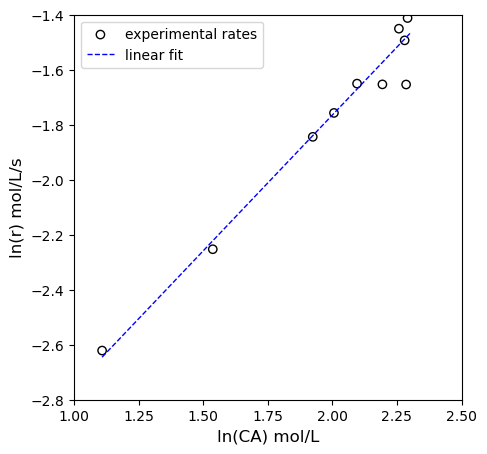

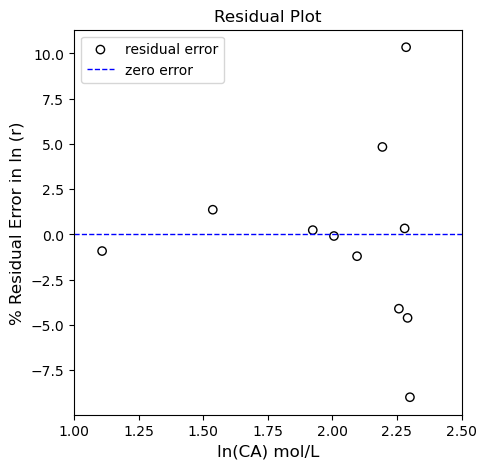

In [33]:
#####################################################################################################
# Define the xdata array and ydata array                                                            #
#####################################################################################################

ydata = np.log(rbdatan)
xdata = np.log(CAdatan)

#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

Y     = ydata
X     = np.vander(xdata,2) #This creates the X matrix shown above, truncating at 1st order

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A      = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
m      = A[0]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1]
b      = A[1]                         #This is a linear model; with the way we define the X matrix, slope is A[0], intercept is A[1] 
SEm    = np.sqrt(COV[0, 0])           #For our definition of the X matrix, standard error in the slope is the first diagonal element in COV
SEb    = np.sqrt(COV[1, 1])           #For our definition of the X matrix, standard error in the intercept is the second diagonal element in COV
tval   = stats.t.ppf(0.975, DOF)      #t distribution for 95% confidence interval t(1 - α/2, DOF), α = 0.05 for 95% confidence interval
CIm    = SEm*tval                     #confidence interval on slope
CIb    = SEb*tval                     #confidence interval on intercept
α      = m                            #slope is equal to the reaction order
k      = np.exp(b)                    #y intercept is equal to ln(k)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'α', 'k']
values = [m  ,  b ,  SSE1,  SST , MSE , RMSE ,  R2, α, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIm:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; overlay data and regressed y(x)                                     #
############################################################################################

plt.figure(1, figsize = (5, 5))
plt.scatter(xdata, ydata, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental rates')
plt.plot(xdata, Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.ylim(-2.8, -1.4)
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('ln(r) mol/L/s', fontsize = 12)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(xdata, (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlim(1.0, 2.5)
plt.xticks(np.arange(1.0, 2.51, 0.25))
plt.xlabel('ln(CA) mol/L', fontsize = 12)
plt.ylabel('% Residual Error in ln (r)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper left')
plt.show()

Unlike the above analysis based on changes in reactant concentration, here, we can tolerate pretty large levels of imprecision -- say standard deviations of roughly 10% -- and still obtain reasonable estimates for both the reaction order $(\alpha = 0.99 \pm 0.15)$ and rate constant $(0.017 \ \mathrm{s^{-1}} \leq k \leq 0.032 \ \mathrm{s^{-1}})$.

```{tip}
Measuring precise changes in the concentration of a reactant as the conversion of that reactant approaches zero is very difficult. When working with real data at low conversion, it is far better to define the rate in terms of product concentration!
```

## Example Problem 05

We next consider a data set where not much has been done systematically. A student has performed a kinetic study of the following reaction using a CSTR.

$$A + 2B \longrightarrow 3C$$

They varied space time (by varying feed flowrate), and they also seem to have been randomly changing the feed concentrations of both $A$ and $B$ with every change in space time. We can propose that the reaction is irreversible and that the rate of reaction depends on concentrations of $A$ and $B$ in a power law model:

$$r = kC_A^\alpha C_B^\beta$$

Please estimate $k$, $\alpha$, and $\beta$.

The data obtained by the student are attached as CSV file. Our lives will be much easier if we first learn how to import that data into Python (as opposed to manually defining numpy arrays containing that data). 

### Importing into a dataframe with pandas

The code in the cell below will import the data as a dataframe using the `pandas` package, which has the display characteristics of a table or spreadsheet. We are using a data frame here primarily to see the data that we have on hand with nice formatting. A minor secondary reason to use dataframes and `pandas` is that these tools are very popular in data analytics, so some exposure is worthwhile even if we do not necessarily *need* dataframes or `pandas` for this exercise. This data includes residence times ($\tau$); feed concentrations of A, B, and C ($C_{Af}$ and $C_{Bf}$); fractional conversion of A measured at at the reactor exit; and effluent concentrations of $A$, $B$, and $C$.

In [34]:
import pandas as pd
dataframe1 = pd.read_csv("CSTRDATA32.csv")
dataframe1

,tau (min),CAf (mol/L),CBf (mol/L),CCf (mol/L),XA,CA (mol/L),CB (mol/L),CC (mol/L)
0,34.877,0.40,1.55,0,0.894,0.042,0.824,1.077
1,0.103,0.83,2.38,0,0.141,0.727,2.209,0.366
2,0.646,0.27,1.00,0,0.158,0.218,0.923,0.118
3,0.923,0.68,2.16,0,0.439,0.392,1.507,0.846
4,0.217,0.39,0.94,0,0.057,0.362,0.806,0.061
5,8.653,0.68,1.56,0,0.613,0.246,0.753,1.371
6,36191.127,0.06,0.13,0,0.881,0.007,0.025,0.170
7,0.774,0.40,1.42,0,0.278,0.296,1.125,0.363
8,423.825,0.10,0.34,0,0.820,0.018,0.188,0.254
9,8.683,0.22,0.85,0,0.533,0.098,0.605,0.366


### Converting the dataframe to a numpy array

We need to do some calculations on this data. It is generally easier to do math on arrays than it is to do math on Data Frames. To facilitate this, we will use a `pandas` function called `pandas.DataFrame.to_numpy()` to convert the dataframe into a 2D numpy array. Once this is done, we can work with the array as usual. 

In [35]:
######################################################################################################
# Convert the dataframe to a numpy array; this allows us to do array calculations as normal          #
######################################################################################################

data      = pd.DataFrame.to_numpy(dataframe1)

######################################################################################################
# Store the variouscolumns in appropriately labelled arrays; not necessary, but more readable        #
######################################################################################################

taudata   = data[:, 0]
CAfdata   = data[:, 1]
CBfdata   = data[:, 2]
CCfdata   = data[:, 3]
XAdata    = data[:, 4]
CAdata    = data[:, 5]
CBdata    = data[:, 6]
CCdata    = data[:, 7]

### Calculating Reaction Rates

The first thing we would like to do is estimate rates of reaction. As discussed earlier in this notebook, when we are working with a single reaction, it is usually preferable to estimate reaction rates from measured product concentrations. This is especially true at short space times and low conversions, where the differences between reactant concentrations are small, and we can see that experimental imprecision leads to challenges in regression analysis.  For this reason, we'll write a balance on species $C$, the product of this reaction:

$$0 = C_{Cf} - C_C + R_C\tau$$

From the data table, we know that $C_{Cf} = 0$ in all experiments. We also know that $R_C = 3r$. We make these substitutions and solve the material balance for $r$ to find:

$$r = \frac{C_C}{3\tau}$$

This is the calculation we'd like to perform first -- estimate the reaction rate at each condition based on product concentration. In the cell below, we will convert the DataFrame to a numpy array, construct arrays for each quantity, and then calculate reaction rates. Once this is done, we'll add the calculated rates as an additional column in the 2D array and convert this back to a Data Frame for display.

In [37]:

######################################################################################################
# Calculate rates of reaction in each experiment                                                     #
######################################################################################################

rdata     = CCdata/3/taudata

######################################################################################################
######################################################################################################
# Next few lines are only really for displaying as data frame, not necessary for calculations        #
######################################################################################################
######################################################################################################

######################################################################################################
# Stack column of rates as a new column in the "data" array; need to reshape 1D array to column      #
######################################################################################################
# print(data)
data_all  = np.hstack([data, rdata.reshape(len(rdata), 1)])
# print(data_all)
######################################################################################################
# Create a list with column labels from original data frame                                          #
######################################################################################################

header    = list(dataframe1.columns)

######################################################################################################
# Append the label for rate with appropriate units to the header                                     #
######################################################################################################

header.append('r (mol/L/min)')

######################################################################################################
# Convert revised data (with rate measurements) to a dataframe; pass header as column labels         #
######################################################################################################

dataframe2 = pd.DataFrame(data_all, columns = header)
dataframe2

,tau (min),CAf (mol/L),CBf (mol/L),CCf (mol/L),XA,CA (mol/L),CB (mol/L),CC (mol/L),r (mol/L/min)
0,34.877,0.40,1.55,0.0,0.894,0.042,0.824,1.077,0.010293
1,0.103,0.83,2.38,0.0,0.141,0.727,2.209,0.366,1.184466
2,0.646,0.27,1.00,0.0,0.158,0.218,0.923,0.118,0.060888
3,0.923,0.68,2.16,0.0,0.439,0.392,1.507,0.846,0.305525
4,0.217,0.39,0.94,0.0,0.057,0.362,0.806,0.061,0.093702
5,8.653,0.68,1.56,0.0,0.613,0.246,0.753,1.371,0.052814
6,36191.127,0.06,0.13,0.0,0.881,0.007,0.025,0.170,0.000002
7,0.774,0.40,1.42,0.0,0.278,0.296,1.125,0.363,0.156331
8,423.825,0.10,0.34,0.0,0.820,0.018,0.188,0.254,0.000200
9,8.683,0.22,0.85,0.0,0.533,0.098,0.605,0.366,0.014050


### Parameter Estimation 

At this point in the analysis, we have data from 23 different experiments. The critical information obtained from these experiments is that, for each experiment, we know $C_A$ and $C_B$ inside of the reactor (since CSTRs are well mixed, effluent concentrations are the same as reactor concentrations), and we know the rate of reaction at each $(C_A, C_B)$ pair. We want to use this information to estimate $k$, $\alpha$, and $\beta$. Our conventional wisdom is that, to determine a parameter, you need to vary the quantity influenced that parameter while holding everything else constant. For example, if you wanted to know $\alpha$, the most straightforward experiment would be one that measures $r$ for various values of $C_A$ while holding $C_B$ constant.  This would allow you to isolate the impact of $C_A$ on reaction rate and therefore estimate $\alpha$.  

The data here was not obtained in that fashion -- instead, we have rates measured in 23 different experiments, and the concentrations of $A$ and $B$ are both varying in each experiment. This means there is no good way for us to isolate the dependence of one from the other. We will consider two different approaches that will allow us to extract parameter estimates from this type of data set.  The first is nonlinear regresion, and the second is multiple linear regression.

#### Parameter Estimation Using Nonlinear Regression

One solution is to use nonlinear regression to minimize an objective function created by calculating the residual sum of squares between measured rates and model predicted rates.  The general approach is that we need to write an objective function that will calculate the quantity that we would like to minimize (here, residual sum of squares) as a function of the parameter(s) that we would like to minimize with respect to. Here, we have a multivariate optimization problem in that we would like to minimize residual sum of squares with respect to $(k, \alpha, \beta)$. We therefore need to construct a multivariate objective function and use `scipy.optimize.minimize()`. We introduced the optimization of univariate scalar functions in [Notebook 28](https://jqbond.github.io/CEN587/Notebooks/587-N28.html), and optimization is covered more broadly in [Python Supplement 10 - minimizing univariate functions](https://jqbond.github.io/CEN587/Supplements/587-S10.html) and [Python Supplement 11 - Minimizing Multivariate Functions](https://jqbond.github.io/CEN587/Supplements/587-S11.html). 

In [29]:
def OBJ(par):
    k     = par[0]
    alpha = par[1]
    beta  = par[2]
    
    CA  = CAdata
    CB  = CBdata
    
    rmod = k*CA**alpha*CB**beta
    rexp = rdata
    SSE  = np.sum((rmod - rexp)**2)
    return SSE

par0 = [1, 1,1]
ans  = opt.minimize(OBJ, par0)
k_opt, α_opt, β_opt = ans.x
print(f' k = {k_opt:8.2E}, α = {α_opt:3.2f}, β = {β_opt:3.2f}')

 k = 3.02E-01, α = 0.99, β = 2.22


From the above analysis, we conclude that:

\begin{align*}
    k &\approx 0.302 \\
    \alpha &\approx 1 \\
    \beta &\approx 2
\end{align*}

#### Estimating Parameters using Multiple Linear Regression

Alternatively, we can linearize this problem.  We know that the rate of reaction should be given by a power law:

$$r = k{C_A}^\alpha {C_B}^\beta$$

This can be linearized as usual by taking logarithms of both sides to give:

$$\ln(r) = \alpha \ln(C_A) + \beta \ln(C_B) + \ln(k)$$

Putting this into matrix form, we would have:

$$XA = Y$$

Where

$X$ is a vandermonde type matrix in which each row is:

$$[i,:] = \begin{bmatrix} \ln(C_A)_i & \ln(C_B)_i & 1 \end{bmatrix}$$

And where

$$A = \begin{bmatrix} \alpha \\ \beta \\ \ln(k) \end{bmatrix}$$

And where $Y$ is a vector of our observable measurements, in this case, ln(r), so each entry is given by:

$$Y[i] = \ln(r)_i$$

With these definitions, we can perform linear regression as usual. The caveate is that we need to create the $X$ matrix manually because `numpy.vander()` is constructed for polynomial regression using univariate polynomials (e.g., functions of only 1 independent variable). Here, we have two independent variables, $\ln(CA)$ and $\ln(C_B)$, and we need to construct the $X$ matrix accordingly. Once this is done, we solve for the linear least squares solution as usual.

$$\hat{A} = (X^\prime X)^{-1}X^\prime Y$$

SSE  =      0.26
SST  =    328.63
MSE  =      0.02
RMSE =      0.15
R2   =      1.00
α    =  9.93e-01 +/- 1.72e-01
β    =  2.03e+00 +/- 2.00e-01
k    =  3.45e-01 (but is between 2.65e-01 and 4.48e-01)


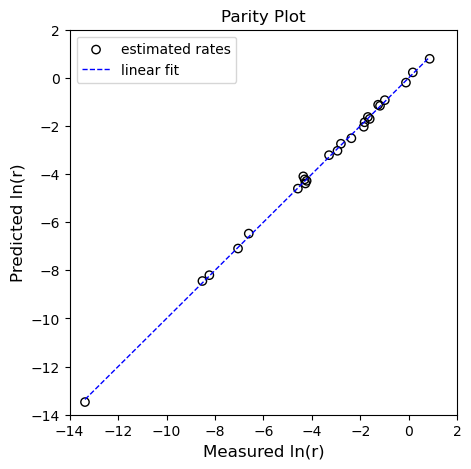

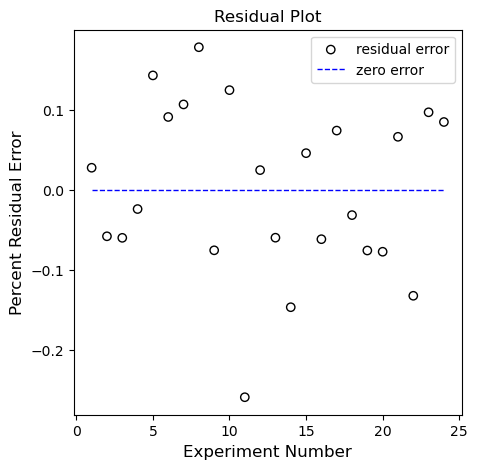

In [30]:
#####################################################################################################
# Define the X matrix and Y array                                                                   #
#####################################################################################################

X      = np.ones((len(rdata),3))
X[:,0] = np.log(CAdata)
X[:,1] = np.log(CBdata)
Y      = np.log(rdata)

#####################################################################################################
# Solve the least squares problem to find the best fit coefficients                                 #
#####################################################################################################

A     = np.linalg.solve(X.T@X, X.T@Y) 

#####################################################################################################
# Workup and analysis for quantifying and visualizing goodness of fit                               #
#####################################################################################################

Ypred  = X@A                          #Calculate discrete array of predicted y values at each x value
Ybar   = np.mean(ydata)               #Calculate the mean of the measured y values, use for SST calculation
Ndata  = len(ydata)                   #Calculate the number of data points/measurementws
SSE1   = np.sum((Y - Ypred)**2)       #Calculate residual sum of squares using intuitive summation formula
SSE2   = (Y - X@A).T@(Y - X@A)        #Calculate residual sum of squares using matrix multiplication; equivalent to SSE1
SST    = np.sum((Y - Ybar)**2)        #Calculate total sum of squares; assumes model is just y_pred = mean(ydata)
MSE    = SSE1/Ndata                   #Calculate mean square error
RMSE   = np.sqrt(MSE)                 #Calculate root mean square error
R2     = 1 - SSE1/SST                 #Calculate R2 (coefficient of determination)
DOF    = len(ydata) - len(A)          #Count degrees of freedom
s2     = SSE1/DOF                     #Estimate variance
COV    = s2*np.linalg.inv(X.T@X)      #Generate the covariance matrix for this fit
α     = A[0]                          #first coefficient is α
β     = A[1]                          #second coefficient is β
b     = A[2]                          #third coefficient is intercept/bias = ln(k)
SEα   = np.sqrt(COV[0, 0])            #Standard error in α
SEβ   = np.sqrt(COV[1, 1])            #Standard error in β
SEb   = np.sqrt(COV[2, 2])            #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF)       #t distribution value for 95% confidence intervals
CIα   = SEα*tval                      #95% confidence interval on α
CIβ   = SEβ*tval                      #95% confidence interval on β
CIb   = SEb*tval                      #95% confidence interval on y-intercept
k     = np.exp(b)

############################################################################################
# Printing results using f strings; create arrays of labels and values                     #
############################################################################################

labels = ['SSE', 'SST','MSE','RMSE', 'R2', 'α', 'β', 'k']
values = [ SSE1,  SST , MSE , RMSE ,  R2 ,  α ,  β ,  k ]

for label, value in zip(labels, values):
    if label == 'α':
        print(f'{label:4s} = {value:9.2e} +/- {CIα:8.2e}')
    elif label == 'β':
        print(f'{label:4s} = {value:9.2e} +/- {CIβ:8.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:9.2e} +/- {CIb:8.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:9.2e} (but is between {np.exp(b-CIb):8.2e} and {np.exp(b+CIb):8.2e})')
    else:
        print(f'{label:4s} = {value:9.2f}')

############################################################################################
# Visualizing results; parity plot                                                         #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(Y, Ypred, marker = 'o', color = 'none', edgecolor = 'black', label = 'estimated rates')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('Measured ln(r)', fontsize = 12)
plt.ylabel('Predicted ln(r)', fontsize = 12)
plt.title('Parity Plot')
plt.xlim(-14.0, 2.0)
plt.ylim(-14.0, 2.0)
plt.legend()
plt.show()

############################################################################################
# Visualizing results; plot of residual errors                                             #
############################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(np.arange(1, len(Y)+1, 1), (Y - Ypred), marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, 1, len(Y), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('Experiment Number', fontsize = 12)
plt.ylabel('Percent Residual Error', fontsize = 12)
plt.title('Residual Plot')
#plt.xlim(-14.0, 2.0)
#plt.ylim(-14.0, 2.0)
plt.legend()
plt.show()

From this analysis, we conclude that

\begin{align*}
    0.265 &\leq \ k \leq 0.448 \ \mathrm{L^2 mol^{-2} min^{-1}}\\
    \alpha &= 0.99 \pm 0.17 \\
    \beta &= 2.03 \pm 0.20 
\end{align*}